# Building Essentiality Vectors for Rich and Minimal Media

This notebook extracts and harmonizes essentiality calls from multiple data sources:

## Set 1: Rich Media (LB)
1. FBA - `rich_media_class`
2. KO experiment (truth) - `essentiality_lb`
3. RB-TnSeq - `essentiality_fraction`

## Set 2: Minimal Media
1. FBA - `minimal_media_class`
2. KO experiment merged (truth) - `essentiality_minimal` with `essentiality_lb` fallback
3. Proteomics - average log2 expression across 7 strains
4. RB-TnSeq merged - `essentiality_fraction` + fitness values

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Connect to database
conn = sqlite3.connect('../berdl_tables.db')

print("Database connected successfully")

Database connected successfully


## Extract Base Gene Features

Start with all genes and their core annotations

In [2]:
# Extract all genes with key identifiers and annotations
genes_df = pd.read_sql("""
    SELECT 
        feature_id,
        old_locus_tag,
        gene_names,
        rast_function,
        length
    FROM genome_features
    ORDER BY feature_id
""", conn)

print(f"Total genes: {len(genes_df):,}")
genes_df.head()

Total genes: 5,852


,feature_id,old_locus_tag,gene_names,rast_function,length
0,ACIAD0006,NaN,NaN,NaN,0
1,ACIAD0055,NaN,NaN,NaN,0
2,ACIAD0056,NaN,NaN,NaN,0
3,ACIAD0057,NaN,NaN,NaN,0
4,ACIAD0058,NaN,NaN,NaN,0


## Set 1: Rich Media Essentiality Vectors

### 1.1 FBA - rich_media_class

In [3]:
# Extract FBA rich media predictions
fba_rich = pd.read_sql("""
    SELECT 
        feature_id,
        rich_media_class,
        rich_media_flux
    FROM genome_features
""", conn)

# Convert to binary essential/non-essential
# essential = essential
# blocked/variable/NaN = non-essential
fba_rich['fba_rich_essential'] = fba_rich['rich_media_class'].map({
    'essential': 1,
    'blocked': 0,
    'variable': 0
})

print("FBA Rich Media Classification:")
print(fba_rich['rich_media_class'].value_counts(dropna=False))
print("\nBinary essentiality:")
print(fba_rich['fba_rich_essential'].value_counts(dropna=False))

fba_rich[['feature_id', 'fba_rich_essential']].head(10)

FBA Rich Media Classification:
rich_media_class
NaN          4986
variable      405
essential     270
blocked       191
Name: count, dtype: int64

Binary essentiality:
fba_rich_essential
NaN    4986
0.0     596
1.0     270
Name: count, dtype: int64


,feature_id,fba_rich_essential
0,ACIAD_RS16655,1.0
1,ACIAD_RS16650,1.0
2,ACIAD_RS16645,NaN
3,ACIAD_RS16640,NaN
4,ACIAD_RS16635,NaN
5,ACIAD_RS16630,NaN
6,ACIAD_RS16625,NaN
7,ACIAD_RS16620,NaN
8,ACIAD_RS16615,NaN
9,ACIAD_RS16610,NaN


### 1.2 KO Experiment (Truth) - essentiality_lb

In [4]:
# Extract KO experiment rich media (LB) essentiality
ko_rich = pd.read_sql("""
    SELECT 
        feature_id,
        essentiality_lb
    FROM genome_features
""", conn)

# Convert to binary essential/non-essential
# essential = essential
# dispensable = non-essential
# uncertain/NaN = unknown
ko_rich['ko_rich_essential'] = ko_rich['essentiality_lb'].map({
    'essential': 1,
    'dispensable': 0,
    'uncertain': np.nan
})

print("KO Rich Media (LB) Classification:")
print(ko_rich['essentiality_lb'].value_counts(dropna=False))
print("\nBinary essentiality:")
print(ko_rich['ko_rich_essential'].value_counts(dropna=False))

ko_rich[['feature_id', 'ko_rich_essential']].head(10)

KO Rich Media (LB) Classification:
essentiality_lb
dispensable    2607
NaN            2447
uncertain       452
essential       346
Name: count, dtype: int64

Binary essentiality:
ko_rich_essential
NaN    2899
0.0    2607
1.0     346
Name: count, dtype: int64


,feature_id,ko_rich_essential
0,ACIAD_RS16655,NaN
1,ACIAD_RS16650,NaN
2,ACIAD_RS16645,NaN
3,ACIAD_RS16640,1.0
4,ACIAD_RS16635,NaN
5,ACIAD_RS16630,0.0
6,ACIAD_RS16625,0.0
7,ACIAD_RS16620,0.0
8,ACIAD_RS16615,0.0
9,ACIAD_RS16610,0.0


### 1.3 RB-TnSeq - essentiality_fraction

Total genes with TnSeq data: 2,181

Essentiality fraction distribution:
count    2181.000000
mean        0.025987
std         0.065682
min         0.000000
25%         0.000000
50%         0.000000
75%         0.033333
max         1.000000
Name: essentiality_fraction, dtype: float64

Binary essentiality (threshold=0.5):
tnseq_essential
0.0    2170
1.0      11
Name: count, dtype: int64


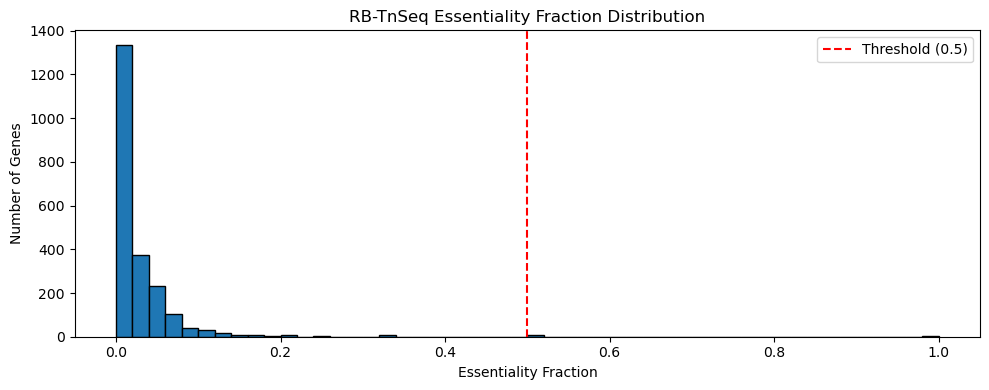

,feature_id,essentiality_fraction,tnseq_essential
0,ACIAD_RS08130,0.076923,0.0
1,ACIAD_RS07265,0.076923,0.0
2,ACIAD_RS02530,0.000000,0.0
3,ACIAD_RS11715,0.000000,0.0
4,ACIAD_RS05470,0.010526,0.0
5,ACIAD_RS08420,0.086957,0.0
6,ACIAD_RS05610,0.000000,0.0
7,ACIAD_RS07875,0.010582,0.0
8,ACIAD_RS08660,0.000000,0.0
9,ACIAD_RS13555,0.000000,0.0


In [5]:
# Extract RB-TnSeq essentiality (unique per gene)
tnseq = pd.read_sql("""
    SELECT DISTINCT
        gene_id as feature_id,
        essentiality_fraction
    FROM gene_phenotypes
    WHERE essentiality_fraction IS NOT NULL
""", conn)

# Convert essentiality_fraction to binary
# High fraction (>= 0.5) = essential in most conditions
# Low fraction (< 0.5) = dispensable in most conditions
# This is a common threshold but we can adjust
tnseq['tnseq_essential'] = (tnseq['essentiality_fraction'] >= 0.5).astype(float)

print(f"Total genes with TnSeq data: {len(tnseq):,}")
print("\nEssentiality fraction distribution:")
print(tnseq['essentiality_fraction'].describe())
print("\nBinary essentiality (threshold=0.5):")
print(tnseq['tnseq_essential'].value_counts())

# Plot distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(tnseq['essentiality_fraction'], bins=50, edgecolor='black')
ax.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
ax.set_xlabel('Essentiality Fraction')
ax.set_ylabel('Number of Genes')
ax.set_title('RB-TnSeq Essentiality Fraction Distribution')
ax.legend()
plt.tight_layout()
plt.savefig('../figures/tnseq_essentiality_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

tnseq[['feature_id', 'essentiality_fraction', 'tnseq_essential']].head(10)

## Set 2: Minimal Media Essentiality Vectors

### 2.1 FBA - minimal_media_class

In [6]:
# Extract FBA minimal media predictions
fba_min = pd.read_sql("""
    SELECT 
        feature_id,
        minimal_media_class,
        minimal_media_flux
    FROM genome_features
""", conn)

# Convert to binary essential/non-essential
fba_min['fba_min_essential'] = fba_min['minimal_media_class'].map({
    'essential': 1,
    'blocked': 0,
    'variable': 0
})

print("FBA Minimal Media Classification:")
print(fba_min['minimal_media_class'].value_counts(dropna=False))
print("\nBinary essentiality:")
print(fba_min['fba_min_essential'].value_counts(dropna=False))

fba_min[['feature_id', 'fba_min_essential']].head(10)

FBA Minimal Media Classification:
minimal_media_class
NaN          4986
variable      322
essential     302
blocked       242
Name: count, dtype: int64

Binary essentiality:
fba_min_essential
NaN    4986
0.0     564
1.0     302
Name: count, dtype: int64


,feature_id,fba_min_essential
0,ACIAD_RS16655,1.0
1,ACIAD_RS16650,1.0
2,ACIAD_RS16645,NaN
3,ACIAD_RS16640,NaN
4,ACIAD_RS16635,NaN
5,ACIAD_RS16630,NaN
6,ACIAD_RS16625,NaN
7,ACIAD_RS16620,NaN
8,ACIAD_RS16615,NaN
9,ACIAD_RS16610,NaN


### 2.2 KO Experiment Merged - essentiality_minimal with essentiality_lb fallback

In [7]:
# Extract both essentiality columns
ko_min = pd.read_sql("""
    SELECT 
        feature_id,
        essentiality_minimal,
        essentiality_lb
    FROM genome_features
""", conn)

# Merge strategy: use essentiality_minimal if available, otherwise use essentiality_lb
ko_min['ko_min_merged'] = ko_min['essentiality_minimal'].fillna(ko_min['essentiality_lb'])

# Convert to binary
ko_min['ko_min_essential'] = ko_min['ko_min_merged'].map({
    'essential': 1,
    'dispensable': 0,
    'uncertain': np.nan
})

print("KO Minimal Media Merged Classification:")
print(ko_min['ko_min_merged'].value_counts(dropna=False))
print("\nBinary essentiality:")
print(ko_min['ko_min_essential'].value_counts(dropna=False))

# Check conflict cases
conflicts = ko_min[
    ko_min['essentiality_minimal'].notna() & 
    ko_min['essentiality_lb'].notna() & 
    (ko_min['essentiality_minimal'] != ko_min['essentiality_lb'])
]
print(f"\nGenes with conflicting essentiality calls: {len(conflicts):,}")
print("\nConflict breakdown:")
print(conflicts.groupby(['essentiality_minimal', 'essentiality_lb']).size())

ko_min[['feature_id', 'ko_min_essential']].head(10)

KO Minimal Media Merged Classification:
ko_min_merged
dispensable    2593
NaN            2447
essential       499
uncertain       313
Name: count, dtype: int64

Binary essentiality:
ko_min_essential
NaN    2760
0.0    2593
1.0     499
Name: count, dtype: int64

Genes with conflicting essentiality calls: 892

Conflict breakdown:
essentiality_minimal  essentiality_lb
dispensable           essential           90
                      uncertain          272
essential             dispensable        125
                      uncertain          136
uncertain             dispensable        251
                      essential           18
dtype: int64


,feature_id,ko_min_essential
0,ACIAD_RS16655,NaN
1,ACIAD_RS16650,NaN
2,ACIAD_RS16645,0.0
3,ACIAD_RS16640,NaN
4,ACIAD_RS16635,NaN
5,ACIAD_RS16630,NaN
6,ACIAD_RS16625,0.0
7,ACIAD_RS16620,0.0
8,ACIAD_RS16615,0.0
9,ACIAD_RS16610,NaN


### 2.3 Proteomics - Average Expression Across 7 Strains

Genes with proteomics data: 2,383

Log2 expression distribution:
count    2383.000000
mean       26.288538
std         3.146611
min        19.180438
25%        24.046647
50%        26.328330
75%        28.439047
max        36.327515
Name: proteomics_avg_log2, dtype: float64

Relative abundance distribution:
count    2.383000e+03
mean     7.591004e+08
std      3.449310e+09
min      5.941376e+05
25%      1.732854e+07
50%      8.425915e+07
75%      3.639214e+08
max      8.623262e+10
Name: proteomics_avg_abundance, dtype: float64


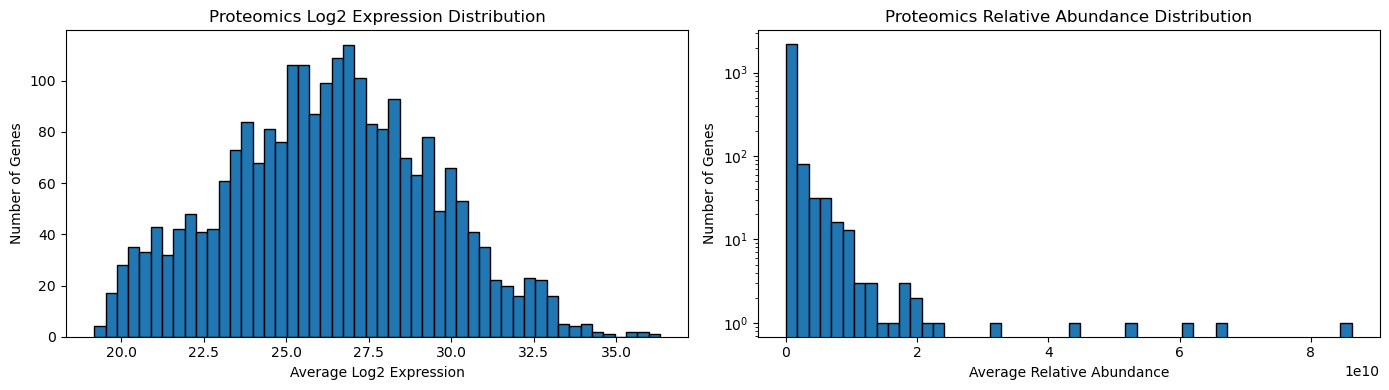

,feature_id,proteomics_avg_log2,proteomics_avg_abundance
0,ACIAD_RS16655,NaN,NaN
1,ACIAD_RS16650,NaN,NaN
2,ACIAD_RS16645,NaN,NaN
3,ACIAD_RS16640,NaN,NaN
4,ACIAD_RS16635,NaN,NaN
5,ACIAD_RS16630,NaN,NaN
6,ACIAD_RS16625,NaN,NaN
7,ACIAD_RS16620,NaN,NaN
8,ACIAD_RS16615,NaN,NaN
9,ACIAD_RS16610,NaN,NaN


In [8]:
# Extract proteomics data
proteomics = pd.read_sql("""
    SELECT 
        feature_id,
        proteomics_avg_ADP1,
        proteomics_avg_ACN2821,
        proteomics_avg_ACN3430,
        proteomics_avg_ACN3425,
        proteomics_avg_ACN2586,
        proteomics_avg_ACN3429,
        proteomics_avg_ACN3427
    FROM genome_features
""", conn)

# These are log2 values - average across all strains
prot_cols = ['proteomics_avg_ADP1', 'proteomics_avg_ACN2821', 'proteomics_avg_ACN3430',
             'proteomics_avg_ACN3425', 'proteomics_avg_ACN2586', 'proteomics_avg_ACN3429',
             'proteomics_avg_ACN3427']

proteomics['proteomics_avg_log2'] = proteomics[prot_cols].mean(axis=1)

# Convert log2 to relative abundance (2^log2)
proteomics['proteomics_avg_abundance'] = 2 ** proteomics['proteomics_avg_log2']

print(f"Genes with proteomics data: {proteomics['proteomics_avg_log2'].notna().sum():,}")
print("\nLog2 expression distribution:")
print(proteomics['proteomics_avg_log2'].describe())
print("\nRelative abundance distribution:")
print(proteomics['proteomics_avg_abundance'].describe())

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Log2 distribution
axes[0].hist(proteomics['proteomics_avg_log2'].dropna(), bins=50, edgecolor='black')
axes[0].set_xlabel('Average Log2 Expression')
axes[0].set_ylabel('Number of Genes')
axes[0].set_title('Proteomics Log2 Expression Distribution')

# Abundance distribution (log scale)
axes[1].hist(proteomics['proteomics_avg_abundance'].dropna(), bins=50, edgecolor='black')
axes[1].set_xlabel('Average Relative Abundance')
axes[1].set_ylabel('Number of Genes')
axes[1].set_title('Proteomics Relative Abundance Distribution')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('../figures/proteomics_expression_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

proteomics[['feature_id', 'proteomics_avg_log2', 'proteomics_avg_abundance']].head(10)

### 2.4 RB-TnSeq Merged - essentiality_fraction + fitness values

Total genes in gene_phenotypes: 2,670
Genes with fitness data: 2,172
Genes without fitness (likely essential): 498

Merged essentiality:
tnseq_merged_essential
0.0    2161
1.0     509
Name: count, dtype: int64


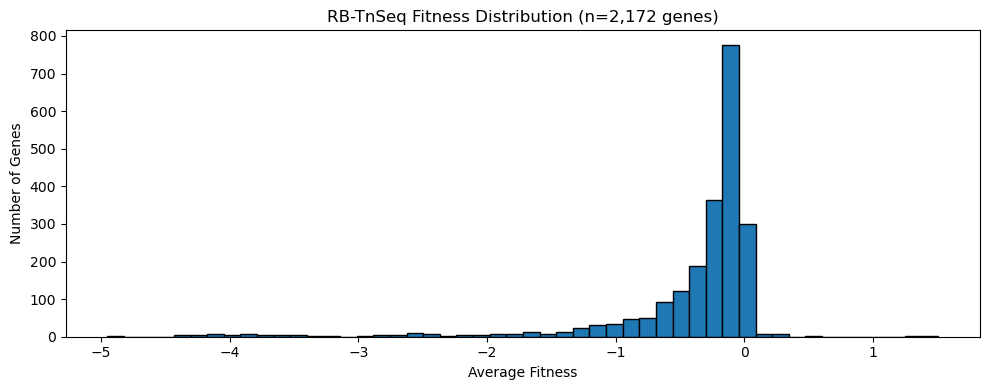

,feature_id,essentiality_fraction,fitness_mean,tnseq_merged_essential
0,ACIAD_RS00005,0.000000,0.016204,0.0
1,ACIAD_RS00010,0.000000,-0.074879,0.0
2,ACIAD_RS00015,0.066667,-0.302288,0.0
3,ACIAD_RS00020,0.000000,-1.592827,0.0
4,ACIAD_RS00025,0.000000,-0.545944,0.0
5,ACIAD_RS00030,0.015152,-0.039746,0.0
6,ACIAD_RS00045,0.000000,-0.551726,0.0
7,ACIAD_RS00050,0.000000,-0.387731,0.0
8,ACIAD_RS00055,0.000000,-0.069329,0.0
9,ACIAD_RS00065,0.041667,-0.028565,0.0


In [9]:
# Extract TnSeq essentiality and fitness
# Aggregate fitness across all phenotypes (max fitness)
tnseq_fitness = pd.read_sql("""
    SELECT 
        gene_id as feature_id,
        MAX(essentiality_fraction) as essentiality_fraction,
        MAX(fitness_avg) as fitness_max,
        MIN(fitness_avg) as fitness_min,
        AVG(fitness_avg) as fitness_mean
    FROM gene_phenotypes
    GROUP BY gene_id
""", conn)

# Create merged essentiality indicator
# If fitness is missing (NaN), the gene is likely essential (no viable transposon insertions)
# If fitness exists, use essentiality_fraction
tnseq_fitness['tnseq_has_fitness'] = tnseq_fitness['fitness_mean'].notna().astype(int)
tnseq_fitness['tnseq_merged_essential'] = np.where(
    tnseq_fitness['fitness_mean'].isna(),
    1.0,  # No fitness = likely essential
    (tnseq_fitness['essentiality_fraction'] >= 0.5).astype(float)  # Has fitness = use essentiality_fraction
)

print(f"Total genes in gene_phenotypes: {len(tnseq_fitness):,}")
print(f"Genes with fitness data: {tnseq_fitness['tnseq_has_fitness'].sum():,}")
print(f"Genes without fitness (likely essential): {(~tnseq_fitness['tnseq_has_fitness'].astype(bool)).sum():,}")
print("\nMerged essentiality:")
print(tnseq_fitness['tnseq_merged_essential'].value_counts())

# Plot fitness distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(tnseq_fitness['fitness_mean'].dropna(), bins=50, edgecolor='black')
ax.set_xlabel('Average Fitness')
ax.set_ylabel('Number of Genes')
ax.set_title(f'RB-TnSeq Fitness Distribution (n={tnseq_fitness["fitness_mean"].notna().sum():,} genes)')
plt.tight_layout()
plt.savefig('../figures/tnseq_fitness_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

tnseq_fitness[['feature_id', 'essentiality_fraction', 'fitness_mean', 'tnseq_merged_essential']].head(10)

## Merge All Essentiality Vectors

In [10]:
# Start with base genes
essentiality_vectors = genes_df.copy()

# Merge Set 1: Rich Media
essentiality_vectors = essentiality_vectors.merge(
    fba_rich[['feature_id', 'fba_rich_essential']], on='feature_id', how='left'
)
essentiality_vectors = essentiality_vectors.merge(
    ko_rich[['feature_id', 'ko_rich_essential']], on='feature_id', how='left'
)
essentiality_vectors = essentiality_vectors.merge(
    tnseq[['feature_id', 'essentiality_fraction', 'tnseq_essential']], on='feature_id', how='left'
)

# Merge Set 2: Minimal Media
essentiality_vectors = essentiality_vectors.merge(
    fba_min[['feature_id', 'fba_min_essential']], on='feature_id', how='left'
)
essentiality_vectors = essentiality_vectors.merge(
    ko_min[['feature_id', 'ko_min_essential']], on='feature_id', how='left'
)
essentiality_vectors = essentiality_vectors.merge(
    proteomics[['feature_id', 'proteomics_avg_log2', 'proteomics_avg_abundance']], on='feature_id', how='left'
)
essentiality_vectors = essentiality_vectors.merge(
    tnseq_fitness[['feature_id', 'fitness_mean', 'tnseq_has_fitness', 'tnseq_merged_essential']], on='feature_id', how='left'
)

print(f"Total genes in essentiality vectors: {len(essentiality_vectors):,}")
print("\nColumn summary:")
print(essentiality_vectors.columns.tolist())
print("\nData availability:")
print(essentiality_vectors.notna().sum())

essentiality_vectors.head(10)

Total genes in essentiality vectors: 5,852

Column summary:
['feature_id', 'old_locus_tag', 'gene_names', 'rast_function', 'length', 'fba_rich_essential', 'ko_rich_essential', 'essentiality_fraction', 'tnseq_essential', 'fba_min_essential', 'ko_min_essential', 'proteomics_avg_log2', 'proteomics_avg_abundance', 'fitness_mean', 'tnseq_has_fitness', 'tnseq_merged_essential']

Data availability:
feature_id                  5852
old_locus_tag               2350
gene_names                  1347
rast_function               3235
length                      5852
fba_rich_essential           866
ko_rich_essential           2953
essentiality_fraction       2181
tnseq_essential             2181
fba_min_essential            866
ko_min_essential            3092
proteomics_avg_log2         2383
proteomics_avg_abundance    2383
fitness_mean                2172
tnseq_has_fitness           2297
tnseq_merged_essential      2297
dtype: int64


,feature_id,old_locus_tag,gene_names,rast_function,length,fba_rich_essential,ko_rich_essential,essentiality_fraction,tnseq_essential,fba_min_essential,ko_min_essential,proteomics_avg_log2,proteomics_avg_abundance,fitness_mean,tnseq_has_fitness,tnseq_merged_essential
0,ACIAD0006,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,ACIAD0055,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACIAD0056,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACIAD0057,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACIAD0058,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ACIAD0059,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ACIAD0060,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ACIAD0141,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ACIAD0171,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
9,ACIAD0224,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Save Essentiality Vectors

In [11]:
# Save to CSV
output_file = '../data/essentiality_vectors.csv'
essentiality_vectors.to_csv(output_file, index=False)
print(f"Essentiality vectors saved to: {output_file}")
print(f"Shape: {essentiality_vectors.shape}")

# Also save metadata about the columns
metadata = {
    'Set 1 (Rich Media)': [
        'fba_rich_essential - FBA prediction (1=essential, 0=non-essential, NaN=no prediction)',
        'ko_rich_essential - KO experiment truth (1=essential, 0=dispensable, NaN=uncertain)',
        'tnseq_essential - RB-TnSeq (1=essential in most conditions, 0=dispensable, NaN=no data)'
    ],
    'Set 2 (Minimal Media)': [
        'fba_min_essential - FBA prediction (1=essential, 0=non-essential, NaN=no prediction)',
        'ko_min_essential - KO experiment merged (1=essential, 0=dispensable, NaN=uncertain)',
        'proteomics_avg_log2 - Average log2 expression across 7 strains',
        'proteomics_avg_abundance - Average relative abundance (2^log2)',
        'tnseq_merged_essential - TnSeq merged (1=essential, 0=dispensable)',
        'fitness_mean - Average fitness across phenotypes',
        'tnseq_has_fitness - Whether gene has fitness data (1=yes, 0=no)'
    ]
}

with open('../data/essentiality_vectors_metadata.txt', 'w') as f:
    f.write("Essentiality Vectors Metadata\n")
    f.write("="*80 + "\n\n")
    for set_name, cols in metadata.items():
        f.write(f"{set_name}:\n")
        for col in cols:
            f.write(f"  - {col}\n")
        f.write("\n")

print("\nMetadata saved to: ../data/essentiality_vectors_metadata.txt")

Essentiality vectors saved to: ../data/essentiality_vectors.csv
Shape: (5852, 16)

Metadata saved to: ../data/essentiality_vectors_metadata.txt


## Summary Statistics

In [12]:
print("="*80)
print("SUMMARY: Data Availability by Source")
print("="*80)

print("\nSET 1: RICH MEDIA")
print("-" * 80)
print(f"FBA rich_media_class:      {essentiality_vectors['fba_rich_essential'].notna().sum():5,} genes")
print(f"KO essentiality_lb:        {essentiality_vectors['ko_rich_essential'].notna().sum():5,} genes")
print(f"TnSeq essentiality:        {essentiality_vectors['tnseq_essential'].notna().sum():5,} genes")

print("\nSET 2: MINIMAL MEDIA")
print("-" * 80)
print(f"FBA minimal_media_class:   {essentiality_vectors['fba_min_essential'].notna().sum():5,} genes")
print(f"KO merged:                 {essentiality_vectors['ko_min_essential'].notna().sum():5,} genes")
print(f"Proteomics:                {essentiality_vectors['proteomics_avg_log2'].notna().sum():5,} genes")
print(f"TnSeq merged:              {essentiality_vectors['tnseq_merged_essential'].notna().sum():5,} genes")

print("\n" + "="*80)
print("Essential Gene Counts")
print("="*80)

print("\nSET 1: RICH MEDIA")
print("-" * 80)
print(f"FBA rich:      {(essentiality_vectors['fba_rich_essential'] == 1).sum():5,} essential")
print(f"KO rich:       {(essentiality_vectors['ko_rich_essential'] == 1).sum():5,} essential")
print(f"TnSeq:         {(essentiality_vectors['tnseq_essential'] == 1).sum():5,} essential")

print("\nSET 2: MINIMAL MEDIA")
print("-" * 80)
print(f"FBA min:       {(essentiality_vectors['fba_min_essential'] == 1).sum():5,} essential")
print(f"KO min:        {(essentiality_vectors['ko_min_essential'] == 1).sum():5,} essential")
print(f"TnSeq merged:  {(essentiality_vectors['tnseq_merged_essential'] == 1).sum():5,} essential")

conn.close()
print("\nDatabase connection closed.")

SUMMARY: Data Availability by Source

SET 1: RICH MEDIA
--------------------------------------------------------------------------------
FBA rich_media_class:        866 genes
KO essentiality_lb:        2,953 genes
TnSeq essentiality:        2,181 genes

SET 2: MINIMAL MEDIA
--------------------------------------------------------------------------------
FBA minimal_media_class:     866 genes
KO merged:                 3,092 genes
Proteomics:                2,383 genes
TnSeq merged:              2,297 genes

Essential Gene Counts

SET 1: RICH MEDIA
--------------------------------------------------------------------------------
FBA rich:        270 essential
KO rich:         346 essential
TnSeq:            11 essential

SET 2: MINIMAL MEDIA
--------------------------------------------------------------------------------
FBA min:         302 essential
KO min:          499 essential
TnSeq merged:    136 essential

Database connection closed.
